Attentions
==========

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/keisen/tf-keras-vis/blob/master/examples/attentions.ipynb)
[![Right click and save](https://img.shields.io/badge/Notebook-Open_In_Github-orange.svg)](https://github.com/keisen/tf-keras-vis/blob/master/docs/examples/attentions.ipynb)


This notebook explains how to get various attention images with Saliency, SmoothGrad, GradCAM, GradCAM++ and ScoreCAM/Faster-ScoreCAM.


Preparation
-----------

### Load libraries

In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[]


### Load tf.keras.Model

In this notebook, we use VGG16 model, but if you want to use other tf.keras.Model, you can do so by modifying the section below.

In [2]:
import tensorflow_addons as tfa

model = tf.keras.models.load_model('vgg16.h5')
#model.summary()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tensorflow_addons/utils/ensure_tf_install.py:37: UserWarning: You are currently using a nightly version of TensorFlow (2.15.0-dev20230906). 
TensorFlow Addons offers no support for the nightly versions of TensorFlow. Some things might work, some other might not. 
If you encounter a bug, do not file an issue on GitHub.
  warnings.warn(


### Load and preprocess images

tf-keras-vis supports batch-wise visualization. Here, we load and preprocess three pictures of goldfish, bear and assault-rifle as input data.

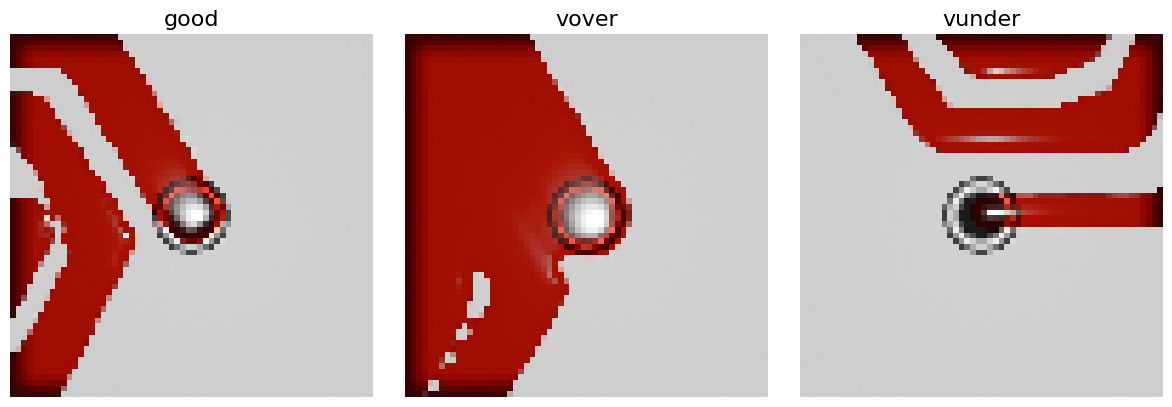

In [7]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Image titles
image_titles = ['good', 'vover', 'vunder']

# Load images and Convert them to a Numpy array
img1 = load_img('synth/test/good/150.jpg', target_size=(64, 64))
img2 = load_img('synth/test/vover/500.jpg', target_size=(64, 64))
img3 = load_img('synth/test/vunder/500.jpg', target_size=(64, 64))
images = np.asarray([np.array(img1), np.array(img2), np.array(img3)])

# Preparing input data for VGG16
X = preprocess_input(images)

# Rendering
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].axis('off')
plt.tight_layout()
plt.show()

Implement functions required to use attentions
----------------------------------------------

### Model modifier

When the softmax activation function is applied to the last layer of model, it may obstruct generating the attention images, so you should replace the function to a linear activation function. Although we create and use `ReplaceToLinear` instance here, we can also use the model modifier function defined by ourselves.

In [8]:
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear

replace2linear = ReplaceToLinear()

# Instead of using the ReplaceToLinear instance above,
# you can also define the function from scratch as follows:
def model_modifier_function(cloned_model):
    cloned_model.layers[-1].activation = tf.keras.activations.linear

### Score function

And then, you **MUST** create `Score` instance or define `score function` that returns target scores. Here, they return the score values corresponding Goldfish, Bear, Assault Rifle.

In [9]:
from tf_keras_vis.utils.scores import CategoricalScore

# 1 is the imagenet index corresponding to Goldfish, 294 to Bear and 413 to Assault Rifle.
score = CategoricalScore([2,3,1])

# Instead of using CategoricalScore object,
# you can also define the function from scratch as follows:
def score_function(output):
    # The `output` variable refers to the output of the model,
    # so, in this case, `output` shape is `(3, 1000)` i.e., (samples, classes).
    return (output[0][1], output[1][3], output[2][4])

## Vanilla Saliency

`Saliency` generates a saliency map that appears the regions of ​​the input image that contributes the most to the output value.

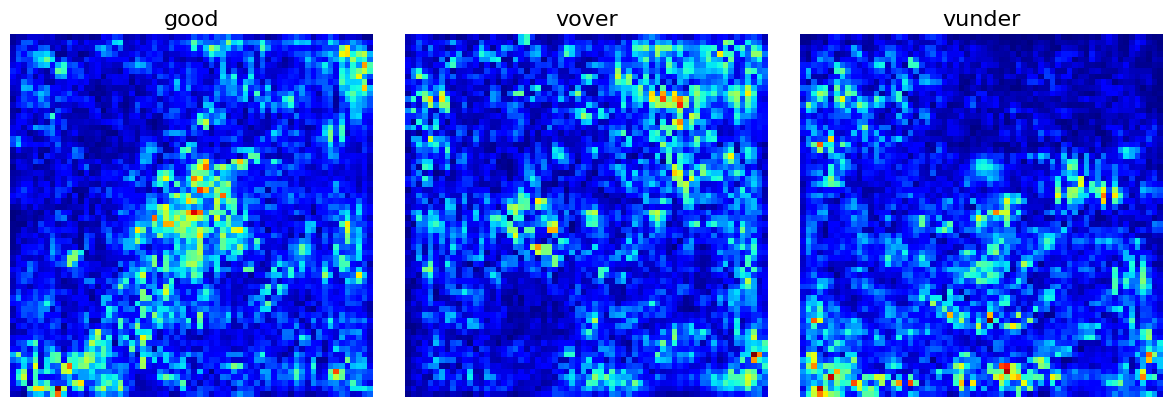

CPU times: user 878 ms, sys: 173 ms, total: 1.05 s
Wall time: 330 ms


In [10]:
%%time
from tensorflow.keras import backend as K
from tf_keras_vis.saliency import Saliency
# from tf_keras_vis.utils import normalize

# Create Saliency object.
saliency = Saliency(model,
                    model_modifier=replace2linear,
                    clone=True)

# Generate saliency map
saliency_map = saliency(score, X)

## Since v0.6.0, calling `normalize()` is NOT necessary.
# saliency_map = normalize(saliency_map)

# Render
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(saliency_map[i], cmap='jet')
    ax[i].axis('off')
plt.tight_layout()
plt.show()

## SmoothGrad

As you can see above, Vanilla Saliency map is too noisy, so let's remove noise in the saliency map using SmoothGrad! SmoothGrad is a method that reduce the noise in saliency map by adding noise to input image.

**Note:** Because SmoothGrad calculates the gradient repeatedly, it might take much time around 2-3 minutes when using CPU.

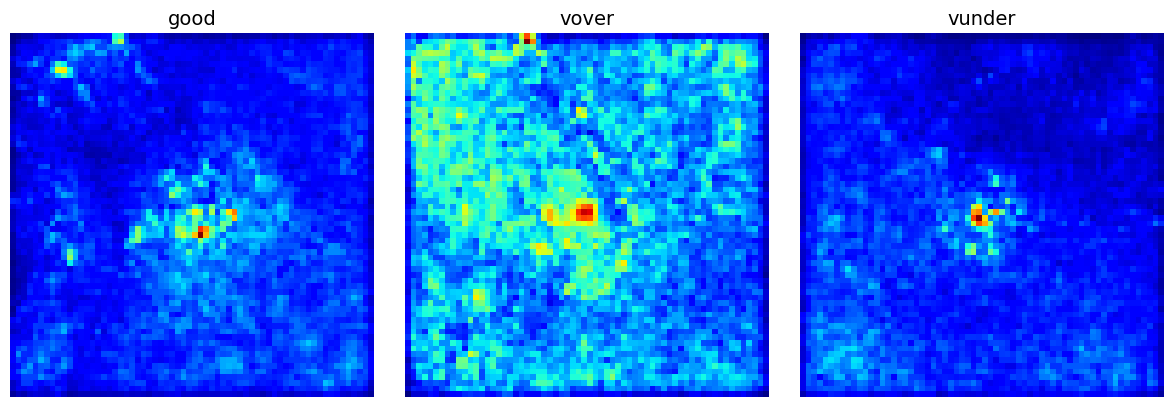

CPU times: user 10.3 s, sys: 1.23 s, total: 11.5 s
Wall time: 2.29 s


In [11]:
%%time

# Generate saliency map with smoothing that reduce noise by adding noise
saliency_map = saliency(score,
                        X,
                        smooth_samples=20, # The number of calculating gradients iterations.
                        smooth_noise=0.20) # noise spread level.

## Since v0.6.0, calling `normalize()` is NOT necessary.
# saliency_map = normalize(saliency_map)

# Render
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=14)
    ax[i].imshow(saliency_map[i], cmap='jet')
    ax[i].axis('off')
plt.tight_layout()
#plt.savefig('images/smoothgrad.png')
plt.show()

## GradCAM

Saliency is one of useful way of visualizing attention that appears the regions of the input image that contributes the most to the output value.
GradCAM is another way of visualizing attention over input. Instead of using gradients of model outputs, it uses of penultimate layer output (that is the convolutional layer just before Dense layers).

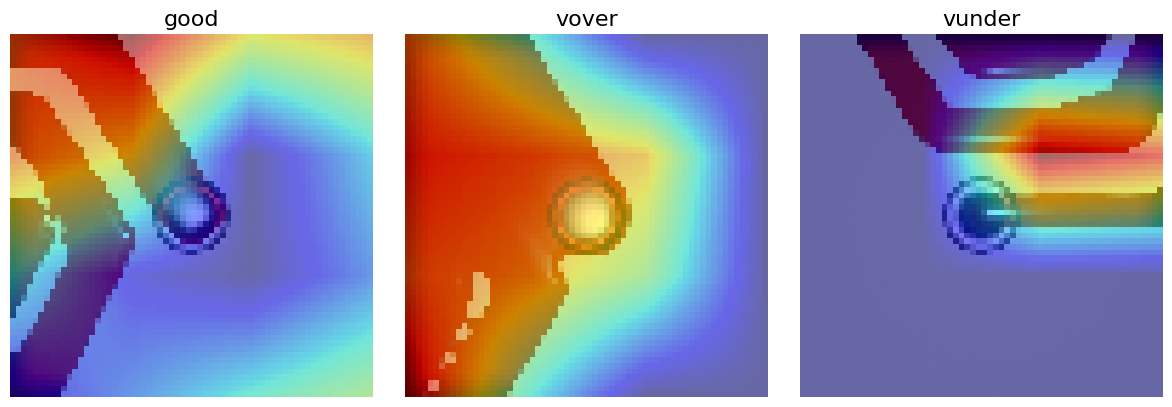

CPU times: user 859 ms, sys: 126 ms, total: 984 ms
Wall time: 295 ms


In [12]:
%%time

from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam

# Create Gradcam object
gradcam = Gradcam(model,
                  model_modifier=replace2linear,
                  clone=True)

# Generate heatmap with GradCAM
cam = gradcam(score,
              X,
              penultimate_layer=-1)

## Since v0.6.0, calling `normalize()` is NOT necessary.
# cam = normalize(cam)

# Render
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5) # overlay
    ax[i].axis('off')
plt.tight_layout()
plt.show()

## GradCAM++

GradCAM++ can provide better visual explanations of CNN model predictions.

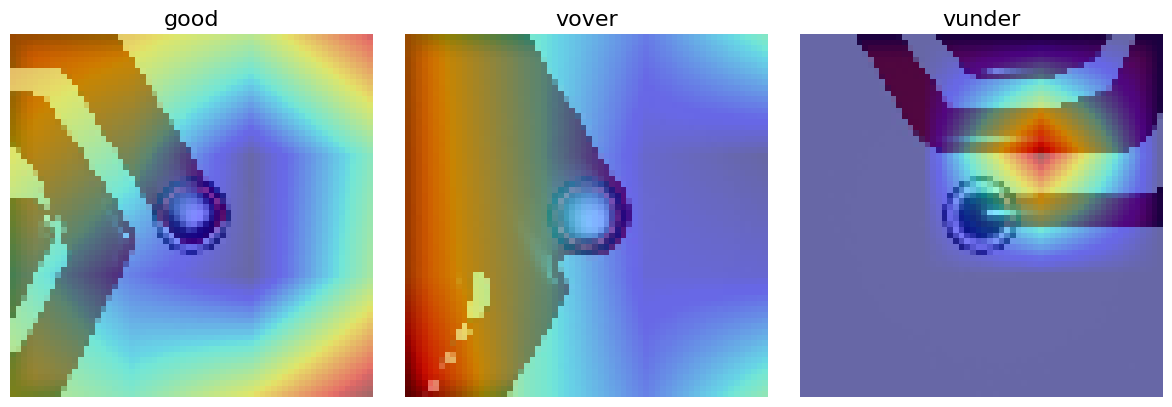

CPU times: user 870 ms, sys: 98.7 ms, total: 969 ms
Wall time: 293 ms


In [13]:
%%time

from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus

# Create GradCAM++ object
gradcam = GradcamPlusPlus(model,
                          model_modifier=replace2linear,
                          clone=True)

# Generate heatmap with GradCAM++
cam = gradcam(score,
              X,
              penultimate_layer=-1)

## Since v0.6.0, calling `normalize()` is NOT necessary.
# cam = normalize(cam)

# Render
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5)
    ax[i].axis('off')
plt.tight_layout()
#plt.savefig('images/gradcam_plus_plus.png')
plt.show()

# Big Run

MobileNetV3Small
MobileNetV3Large
ResNet50V2
vgg16
DenseNet169
MobileNetV2
Xception
DenseNet201
vgg19


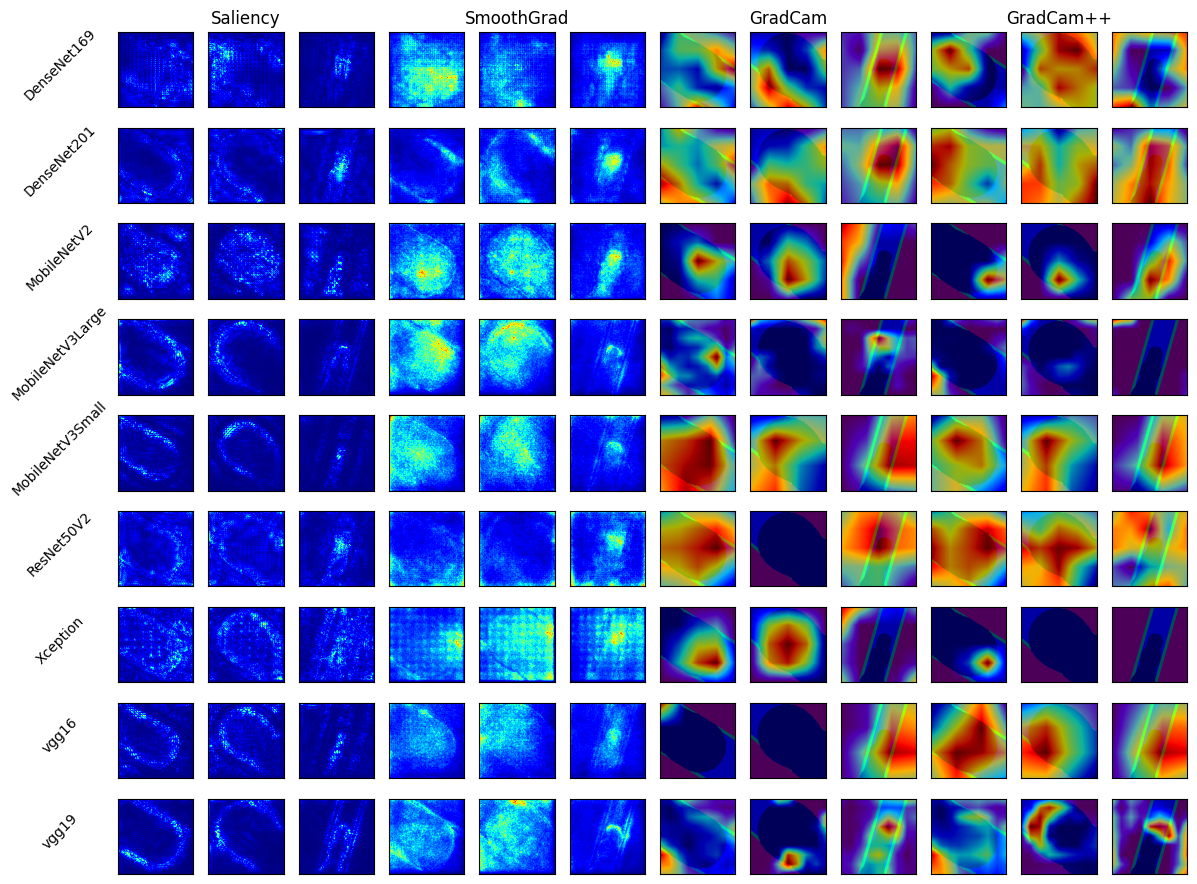

In [98]:
%reload_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import tensorflow as tf

import tensorflow_addons as tfa
import os

from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
replace2linear = ReplaceToLinear()


from tf_keras_vis.utils.scores import CategoricalScore
from tensorflow.keras import backend as K
from tf_keras_vis.saliency import Saliency

from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus

# 1 is the imagenet index corresponding to Goldfish, 294 to Bear and 413 to Assault Rifle.
score = CategoricalScore([1, 3, 4])



# assign directory
directory = 'models'
models = {}
# iterate over files in
# that directory
for filename in os.listdir(directory):
	f = os.path.join(directory, filename)
	# checking if it is a file
	if os.path.isfile(f):
		models[filename.split('.')[0]] = tf.keras.models.load_model(f)

# Image titles
image_titles = ['perfect', 'v_over', 'v_under']

# Load images and Convert them to a Numpy array
img1 = tf.keras.preprocessing.image.load_img('5_class_guides_variance/perfect/perfect789.png', target_size=(150, 150))
img2 = tf.keras.preprocessing.image.load_img('5_class_guides_variance/v_over/v_over897.png', target_size=(150, 150))
img3 = tf.keras.preprocessing.image.load_img('5_class_guides_variance/v_under/v_under690.png', target_size=(150, 150))
images = np.asarray([np.array(img1), np.array(img2), np.array(img3)])

X={}
# Preparing input data for each model
for k in models:
	if "Dense" in k:
		X[k] = tf.keras.applications.densenet.preprocess_input(images)
	elif "vgg19" in k:
		X[k] = tf.keras.applications.vgg19.preprocess_input(images)
	elif "vgg16" in k:
		X[k] = tf.keras.applications.vgg16.preprocess_input(images)
	elif "MobileNetV3" in k:
		X[k] = tf.keras.applications.mobilenet_v3.preprocess_input(images).astype(np.float32)
	elif "MobileNetV2" in k:
		X[k] = tf.keras.applications.mobilenet_v2.preprocess_input(images).astype(np.float32)
	elif "ResNet" in k:
		X[k] = tf.keras.applications.resnet_v2.preprocess_input(images).astype(np.float32)
	elif "Xception" in k:
		X[k] = tf.keras.applications.xception.preprocess_input(images).astype(np.float32)


saliency_maps = []
smooth_grads = []
gradcams = []
gradcamspp = []
for m in models:
	# Create Saliency object.
	print(m)
	saliency = Saliency(models[m],
						model_modifier=replace2linear,
						clone=True)

	# Generate saliency map
	saliency_maps.append(saliency(score, X[m]))
	# Generate SmoothGrad
	smooth_grads.append(saliency(score,
                        X[m],
                        smooth_samples=20, # The number of calculating gradients iterations.
                        smooth_noise=0.20)) # noise spread level.
	
	# Create Gradcam object
	gradcam = Gradcam(models[m],
                  model_modifier=replace2linear,
                  clone=True)

	# Generate heatmap with GradCAM
	gradcams.append(gradcam(score,
              X[m],
              penultimate_layer=-1))
	
	# Create GradcamPlusPlus object
	gradcampp = GradcamPlusPlus(models[m],
                  model_modifier=replace2linear,
                  clone=True)

	# Generate heatmap with GradcamPlusPlus
	gradcamspp.append(gradcampp(score,
              X[m],
              penultimate_layer=-1))
	
	

# Render
f, ax = plt.subplots(nrows=len(models), ncols=12, figsize=(12,len(models)))
y=0
ax[0][1].set_title("Saliency")
ax[0][4].set_title("SmoothGrad")
ax[0][7].set_title("GradCam")
ax[0][10].set_title("GradCam++")
for m in sorted(models):
	ax[y][0].set_ylabel(m, rotation=45)
	ax[y][0].yaxis.set_label_coords(-0.7, 0.5)
	
	for x in range(3):
		ax[y][x].imshow(saliency_maps[y][x], cmap='jet')
		ax[y][x].set_xticks([])
		ax[y][x].set_yticks([])
	for x in range(3):
		ax[y][x+3].imshow(smooth_grads[y][x], cmap='jet')
		ax[y][x+3].set_xticks([])
		ax[y][x+3].set_yticks([])
	for x in range(3):
		heatmap = np.uint8(cm.jet(gradcams[y][x])[..., :3] * 255)
		ax[y][x+6].imshow(images[x])
		ax[y][x+6].imshow(heatmap, cmap='jet', alpha=0.7) # overlay
		ax[y][x+6].set_xticks([])
		ax[y][x+6].set_yticks([])
	for x in range(3):
		heatmap = np.uint8(cm.jet(gradcamspp[y][x])[..., :3] * 255)
		ax[y][x+9].imshow(images[x])
		ax[y][x+9].imshow(heatmap, cmap='jet', alpha=0.7) # overlay
		ax[y][x+9].set_xticks([])
		ax[y][x+9].set_yticks([])
	y+=1

plt.tight_layout()
plt.show()

